In [2]:
pip install torch torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.9 MB/s eta 0:00:00


Processing...
Done!


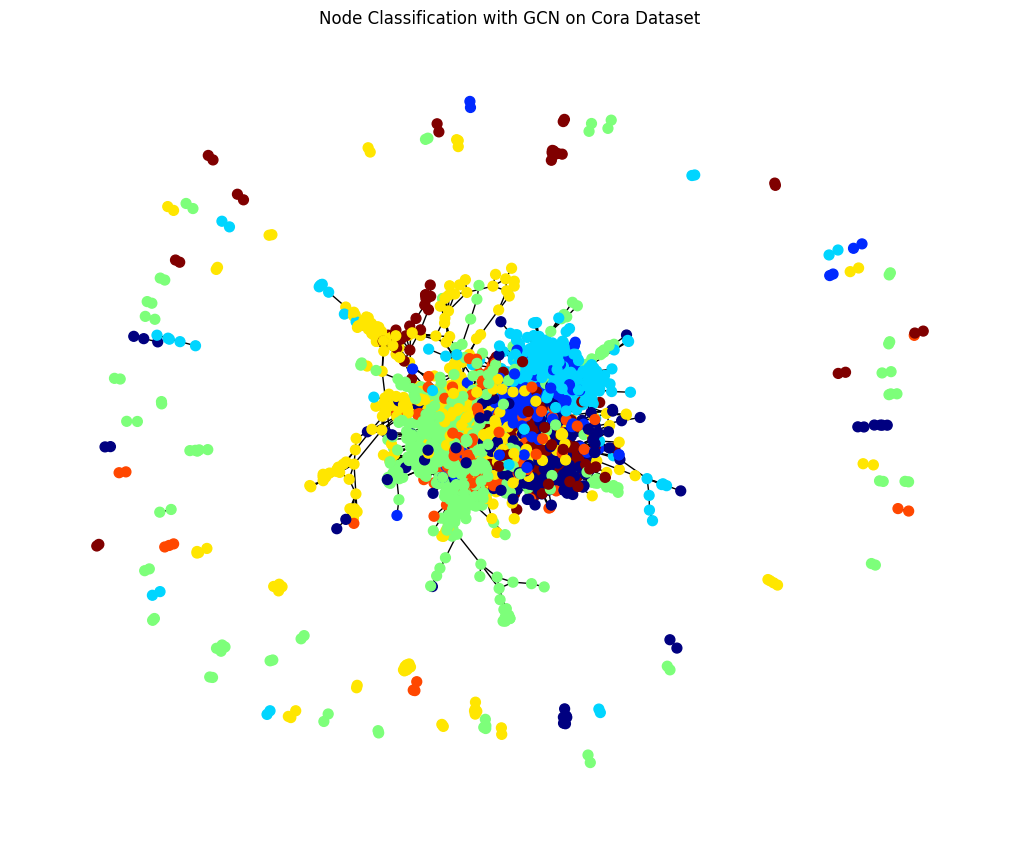

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Define a simple GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Set up the model and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_features, 16, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model
for epoch in range(200):
    train()

# Get model predictions
model.eval()
out = model(data)
pred = out.argmax(dim=1)

# Convert the graph to a NetworkX graph for visualization
G = to_networkx(data, to_undirected=True)
colors = pred.cpu().numpy()  # Use predictions as node colors

# Plot the graph with the predicted node classes
plt.figure(figsize=(10, 8))
nx.draw(G, node_color=colors, cmap=plt.get_cmap('jet'), node_size=50, with_labels=False)
plt.title("Node Classification with GCN on Cora Dataset")
plt.show()
